<a href="https://colab.research.google.com/github/prabhupad26/mnist_flask_solution/blob/master/EMNIST_DATA_pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import torch
from torchvision import datasets
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim
import cv2

In [0]:
transform = transforms.ToTensor()
num_workers = 0
batch_size = 40

In [34]:
train_data = datasets.MNIST(root='data', train= True, download=True, transform=transform)
test_data = datasets.MNIST(root='data', train= False, download=True, transform=transform)

  0%|          | 0/9912422 [00:00<?, ?it/s]

9920512it [00:00, 27882819.56it/s]                            


Extracting data/MNIST/raw/train-images-idx3-ubyte.gz


32768it [00:00, 447223.55it/s]
  1%|          | 16384/1648877 [00:00<00:11, 144394.74it/s]

Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz


1654784it [00:00, 7133492.59it/s]                            
8192it [00:00, 185269.65it/s]


Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz
Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz
Processing...
Done!


In [0]:
train_loader = torch.utils.data.DataLoader(train_data,
                                              batch_size= batch_size,
                                              num_workers= num_workers)
test_loader = torch.utils.data.DataLoader(test_data, 
                                             batch_size = batch_size, 
                                             num_workers = num_workers)

tensor([5, 0, 4, 1, 9, 2, 1, 3, 1, 4, 3, 5, 3, 6, 1, 7, 2, 8, 6, 9, 4, 0, 9, 1,
        1, 2, 4, 3, 2, 7, 3, 8, 6, 9, 0, 5, 6, 0, 7, 6])
torch.Size([40, 1, 28, 28])


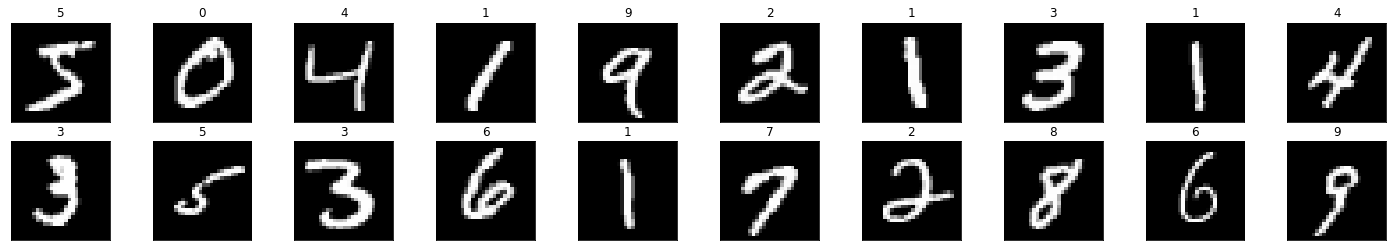

In [36]:
dataiter = iter(train_loader)
images , labels = dataiter.next()
print(labels)
print(images.size())
images = images.numpy()
fig = plt.figure(figsize= (25,4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks= [], yticks= [])
    ax.imshow(np.squeeze(images[idx]),cmap = 'gray')
    ax.set_title(str(labels[idx].item()))

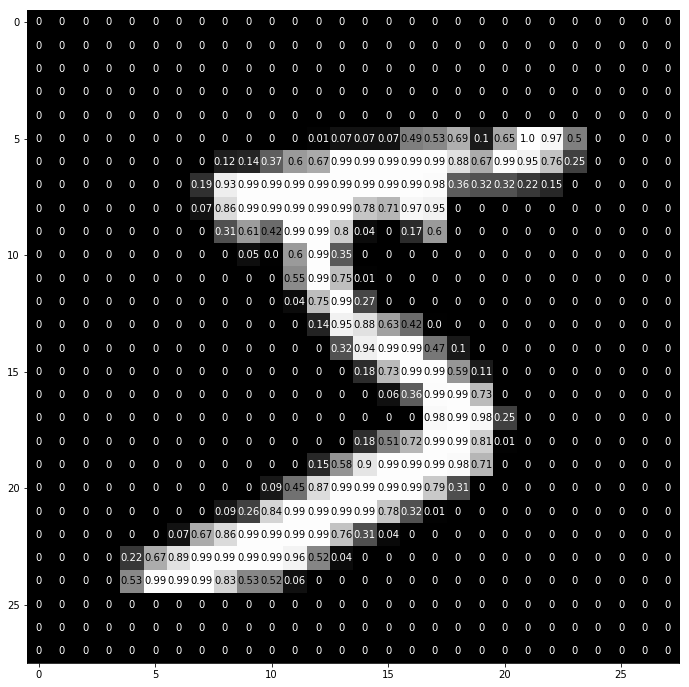

In [37]:
img = np.squeeze(images[0])
fig = plt.figure(figsize=(12,12))
ax  = fig.add_subplot(111)
ax.imshow(img, cmap='gray')
width , height = img.shape
thresh = img.max()/ 2.5
for x in range(width):
    for y in range (height):
        val = round(img[x][y],2 ) if img[x][y] != 0 else 0
        ax.annotate(str(val),xy = (y,x),
                    horizontalalignment= 'center',
                    verticalalignment = 'center',
                    color = 'white' if img[x][y] < thresh else 'black'
                   )

In [3]:
# Declaring a neural network

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(28*28, 512)
        self.fc2 = nn.Linear(512, 10)
        self.dropout = nn.Dropout(0.2)
    def forward(self, x):
        x = x.view(-1, 28*28)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        return x
model = Net()
model.parameters

<bound method Module.parameters of Net(
  (fc1): Linear(in_features=784, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=10, bias=True)
  (dropout): Dropout(p=0.2)
)>

In [0]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001)

In [0]:
model.train()
epochs = 20
for epoch in range(epochs):
    train_loss = 0.0    
    for data, target in train_loader:
        optimizer.zero_grad()
        output = model.forward(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * data.size(0)
    
    train_loss = train_loss / len(train_loader.dataset)
    print("Epoch {} : Training loss : {:.6f}".format(epoch+1, train_loss))

Epoch 1 : Training loss : 2.186354
Epoch 2 : Training loss : 1.792184
Epoch 3 : Training loss : 1.324796
Epoch 4 : Training loss : 0.985337
Epoch 5 : Training loss : 0.792753
Epoch 6 : Training loss : 0.681447
Epoch 7 : Training loss : 0.608774
Epoch 8 : Training loss : 0.557384
Epoch 9 : Training loss : 0.521409
Epoch 10 : Training loss : 0.492992
Epoch 11 : Training loss : 0.471643
Epoch 12 : Training loss : 0.452519
Epoch 13 : Training loss : 0.437859
Epoch 14 : Training loss : 0.425085
Epoch 15 : Training loss : 0.414453
Epoch 16 : Training loss : 0.405508
Epoch 17 : Training loss : 0.395953
Epoch 18 : Training loss : 0.388431
Epoch 19 : Training loss : 0.380581
Epoch 20 : Training loss : 0.375128


In [0]:
test_loss = 0
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

model.eval()

for data, target in test_loader:
    output = model(data)
    loss = criterion(output,target)
    test_loss += loss.item()*data.size(0)
    _, preds = torch.max(output, 1)
    correct = np.squeeze(preds.eq(target.data.view_as(preds)))
    for i in range(batch_size):
        label = target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1
test_loss = test_loss/len(test_loader.dataset)
print("Test loss : {:.6f}\n".format(test_loss))

Test loss : 0.338506



In [0]:
for i in range(10):
    print('Test accuracy of %5s : %2d%% (%2d / %2d )' % ( str(i), 100. * class_correct[i] / class_total[i], 
          np.sum(class_correct[i]), np.sum(class_total[i])))
print("Total accuracy : %2d%% (%2d / %2d)" % (100. *np.sum(class_correct) / np.sum(class_total) , 
                                              np.sum(class_correct), np.sum(class_total)))

Test accuracy of     0 : 97% (959 / 980 )
Test accuracy of     1 : 97% (1108 / 1135 )
Test accuracy of     2 : 86% (897 / 1032 )
Test accuracy of     3 : 89% (904 / 1010 )
Test accuracy of     4 : 92% (906 / 982 )
Test accuracy of     5 : 84% (751 / 892 )
Test accuracy of     6 : 93% (891 / 958 )
Test accuracy of     7 : 90% (927 / 1028 )
Test accuracy of     8 : 86% (845 / 974 )
Test accuracy of     9 : 87% (881 / 1009 )
Total accuracy : 90% (9069 / 10000)


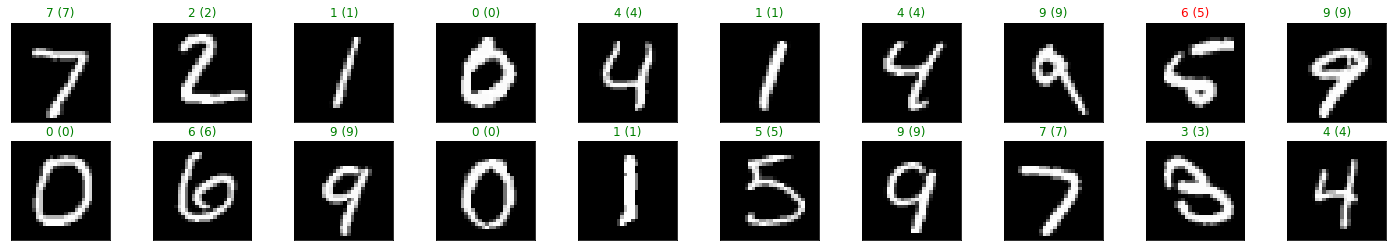

In [38]:
dataiter = iter(test_loader)
images, labels = dataiter.next()
output = model(images)
_, preds = torch.max(output, 1)
images = images.numpy()

fig = plt.figure(figsize=(25,4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks = [], yticks = [])
    ax.imshow(np.squeeze(images[idx]), cmap='gray')
    ax.set_title("{} ({})".format(str(preds[idx].item()), str(labels[idx].item())), 
                 color= ("green" if preds[idx] == labels[idx] else "red"))

In [0]:
images, labels = dataiter.next()
# model(images)
images[0].shape

torch.Size([1, 28, 28])

In [0]:
optimizer.state_dict()

{'param_groups': [{'dampening': 0,
   'lr': 0.001,
   'momentum': 0,
   'nesterov': False,
   'params': [140011899428224,
    140011899426208,
    140011899426352,
    140011899425416],
   'weight_decay': 0}],
 'state': {}}

In [0]:
torch.save({'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict()
            },'mnist_model_A')

In [0]:
model = Net()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001)

checkpoint = torch.load('mnist_model_A')
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

In [0]:
test_loss = 0
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

model.eval()

for data, target in test_loader:
    output = model(data)
    loss = criterion(output,target)
    test_loss += loss.item()*data.size(0)
    _, preds = torch.max(output, 1)
    correct = np.squeeze(preds.eq(target.data.view_as(preds)))
    for i in range(batch_size):
        label = target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1
test_loss = test_loss/len(test_loader.dataset)
print("Test loss : {:.6f}\n".format(test_loss))

In [0]:
ls

data/  mnist_model_A  pil_read_test.png  sample_data/


In [0]:
from PIL import Image

In [0]:
  read_img = Image.open("sample.png")
  read_img = read_img.convert('L')

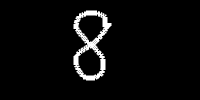

In [27]:
read_img

In [0]:
read_imgpreprocess = transforms.Compose([
	   transforms.Resize(28),
	   transforms.CenterCrop(28),
	   transforms.ToTensor()
	])
preprocess = transforms.Compose([
	   transforms.Resize(28),
	   transforms.CenterCrop(28),
	   transforms.ToTensor()
	])

In [29]:
img_tensor = preprocess(read_img)
img_tensor.reshape(-1,1).shape

torch.Size([784, 1])

In [30]:
output = model(img_tensor.reshape(-1,1))
_, preds = torch.max(output, 1)
preds

tensor([5])

In [32]:
model(img_tensor.reshape(-1,1))

tensor([[2.2951, 0.2650, 1.4187, 0.8311, 0.2874, 3.6584, 3.1486, 0.0000, 1.4093,
         0.1660]], grad_fn=<ReluBackward0>)

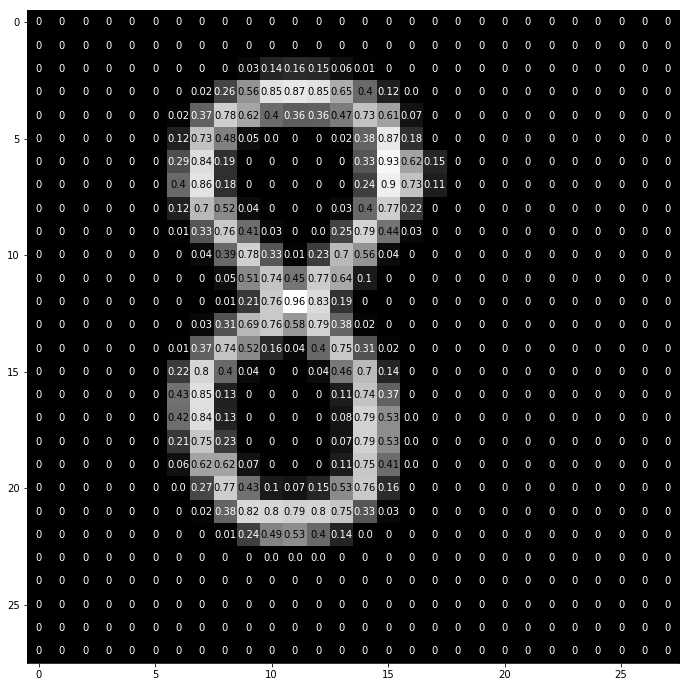

In [39]:
img = np.squeeze(img_tensor.numpy())
fig = plt.figure(figsize=(12,12))
ax  = fig.add_subplot(111)
ax.imshow(img, cmap='gray')
width , height = img.shape
thresh = img.max()/ 2.5
for x in range(width):
    for y in range (height):
        val = round(img[x][y],2 ) if img[x][y] != 0 else 0
        ax.annotate(str(val),xy = (y,x),
                    horizontalalignment= 'center',
                    verticalalignment = 'center',
                    color = 'white' if img[x][y] < thresh else 'black'
                   )